In [ ]:
# register this notebook ('name')

In [1]:
%load_ext autoreload
%autoreload 2
main_dir = r'../../..'
data_path = main_dir+'/BayDS/Data'
import sys
sys.path.append(main_dir)
from typing import List, Set, Dict, Optional, Any, Tuple, Type, Union

from BayDS.lib.pipeline import *
from BayDS.lib.io import *

import os


## Code to make pipeline node

In [3]:
data = pd.read_pickle(f'{data_path}/06-LabelEncodingSuperLast/data.pkl')

In [4]:
X = data[data.isFraud>=0].drop('isFraud',axis=1)
test = data[data.isFraud<0].drop('isFraud',axis=1)
y= data[data.isFraud>=0].isFraud

In [6]:
import yaml
categorical_features = yaml.load(open(f'{data_path}/categorical_columns.yaml','r'))
numerical_features = yaml.load(open(f'{data_path}/numerical_columns.yaml','r'))
bad_features = yaml.load(open(f'{data_path}/bad_for_training_features.yaml','r'))

categorical_features = [f for f in categorical_features if f not in bad_features]
all_features =  [f for f in X.columns if f not in bad_features]

c:\python36\lib\site-packages\ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  
c:\python36\lib\site-packages\ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\python36\lib\site-packages\ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


In [18]:
for f in categorical_features:
    if f not in X.columns:
        print(f"Lost {f}")
#         categorical_features.remove(f)
categorical_features = [f for f in categorical_features if f in X.columns]

In [19]:
for f in numerical_features:
    if f not in X.columns:
        print(f"Lost {f}")
#         numerical_features.remove(f)
numerical_features = [f for f in numerical_features if f in X.columns]

In [7]:
from BayDS.lib.training import *

Using TensorFlow backend.
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as

In [20]:
drop_big_categorical_features = []
for col in categorical_features:
    if len(data[col].value_counts()) > 50:
        drop_big_categorical_features.append(col)
        print(col, len(data[col].value_counts()))

card_id 19226
new_card_id 144827
OSVersion 88
device_version 380
BrowserVersion 54
id_13 56
id_17 128
id_19 569
id_20 548
id_30 88
id_31 173
id_33 462
DeviceInfo 2800
P_emaildomain 61
R_emaildomain 61
card1 9118
card2 497
card3 97
card5 84
addr1 442
device_version 380
id_02__id_20 270750
id_02__D8 258079
D11__DeviceInfo 3680
DeviceInfo__P_emaildomain 8978
P_emaildomain__C2 6793
card2__dist1 31408
card1__card5 18808
card2__id_20 9240
card5__P_emaildomain 1574
addr1__card1 55370
uid 11014
uid2 11442
uid3 52025
uid4 129426
uid5 91344
bank_type 726
product_type 30362


In [14]:
# X.drop(features_to_drop,axis=1,inplace=True)
# test.drop(features_to_drop,axis=1,inplace=True)
# use_for_train_features =  [f for f in all_features if f not in drop_big_categorical_features]

In [15]:
# categorical_features =  [f for f in categorical_features if f not in drop_big_categorical_features]

In [21]:
for col in X.columns:
    if str(X[col].dtype) == 'datetime64[ns]':
        print (col, X[col].dtype)
        X[col] = pd.to_timedelta(X[col]).map(lambda qq:qq.days)
        test[col] = pd.to_timedelta(test[col]).map(lambda qq:qq.days)
#         X[col] = X[col].astype(datetime.datetime)

Date datetime64[ns]
start_date datetime64[ns]


In [22]:
from sklearn.model_selection import GroupKFold

NFOLDS = 6
folds = GroupKFold(n_splits=NFOLDS)


In [23]:
params = {
          'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }
train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 500,
        'n_estimators': 10000,
        'averaging': 'usual',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
    }

Fold 1 started at Mon Sep 30 23:38:23 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.998939	training's auc: 0.998939	valid_1's auc: 0.908065	valid_1's auc: 0.908065
[1000]	training's auc: 0.999999	training's auc: 0.999999	valid_1's auc: 0.914557	valid_1's auc: 0.914557
[1500]	training's auc: 1	training's auc: 1	valid_1's auc: 0.916772	valid_1's auc: 0.916772
Early stopping, best iteration is:
[1335]	training's auc: 1	training's auc: 1	valid_1's auc: 0.916277	valid_1's auc: 0.916277
Fold 2 started at Tue Oct  1 00:01:23 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.99896	training's auc: 0.99896	valid_1's auc: 0.939128	valid_1's auc: 0.939128
[1000]	training's auc: 0.999999	training's auc: 0.999999	valid_1's auc: 0.94353	valid_1's auc: 0.94353
[1500]	training's auc: 1	training's auc: 1	valid_1's auc: 0.944065	valid_1's auc: 0.944065
Early stopping, best iteration is:
[1260]	training's auc: 1	traini

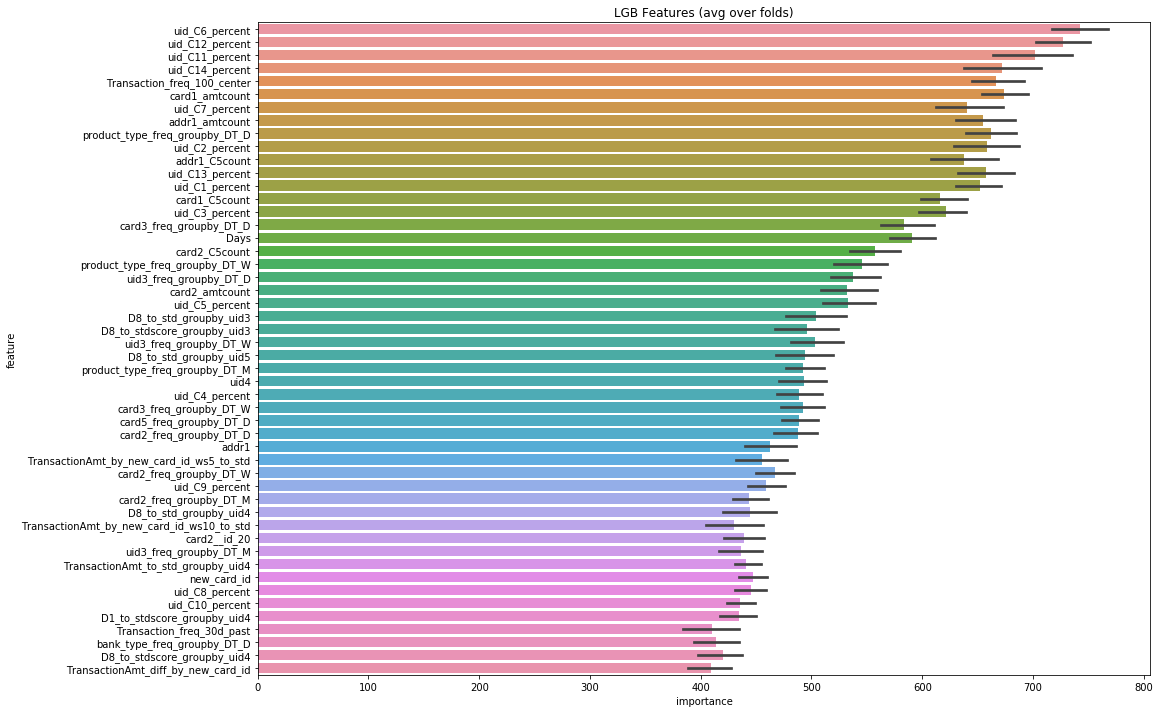

In [25]:
result_dict = train_model_classification_vb( 
                                             X=X, X_test=test, columns=all_features,
                                             y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=X['DT_M'])


In [26]:
import pickle
pickle.dump(result_dict,open(f'{data_path}/results_dict_lightgbm-work-2.pkl','wb'))

In [28]:
pd.DataFrame(result_dict['oof'], columns=['isFraud'], index=X.index).to_csv(f'{data_path}/oof_lightgbm-work-1.csv')

pd.DataFrame(result_dict['prediction'], columns=['isFraud'], index=test.index).to_csv(f'{data_path}/prediction_lightgbm-work-1.csv')

sample_submission = pd.read_csv(data_path + '/sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_dict['prediction'], columns=['isFraud'], index=test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv(f'{data_path}/lightgbm-work-1_sub.csv')

FileNotFoundError: [Errno 2] File b'E:/Kaggle/05-LabelEncoded-last/sample_submission.csv' does not exist: b'E:/Kaggle/05-LabelEncoded-last/sample_submission.csv'